In [1]:
import pandas as pd
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tensorflow
from tensorflow import keras
from tqdm import tqdm
import pickle
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.applications import vgg16
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

Using TensorFlow backend.


In [2]:
tensorflow.__version__

'2.1.0'

In [3]:
data_path_train = "DATA_BASE\DATA_BASE_TRAIN_LARGER\IMAGES_PRESPROCESSED_LARGER\CLEAN"

data_path_test = "DATA_BASE\DATA_BASE_TEST\IMAGES_PREPROCESSED_TEST\CLEAN"

In [4]:
def blur_image(image):
    
    return cv2.GaussianBlur(image, (3, 3), 0)  # Kernel size (7,7)


train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0.1,
        horizontal_flip=False,
        preprocessing_function=blur_image
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        data_path_train,
        target_size=(224, 224),  # all images will be resized to 240x240
        batch_size=16,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        data_path_test,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        shuffle = False
)

Found 3922 images belonging to 3 classes.
Found 840 images belonging to 3 classes.


In [5]:
from tensorflow.python.client import device_lib

In [6]:
# List available GPU devices
physical_devices = tensorflow.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth for the first GPU device
        tensorflow.config.set_logical_device_configuration(
            physical_devices[0],
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        #tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
        #print("Memory growth enabled for GPU")
    except RuntimeError as e:
        # Memory growth must be set before any initialization
        print(e)
else:
    print("No GPU found")


# Enable GPU memory growth to avoid memory allocation errors
physical_devices = tensorflow.config.list_physical_devices('GPU')
#tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)



device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2592911642268824447,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4963958784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14227203462207489475
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [7]:
tensorboard = TensorBoard(log_dir='./VGG16logs', histogram_freq=0,
                          write_graph=True, write_images=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [8]:
from tensorflow.keras.applications import VGG16

In [9]:
# Load the VGG16 base model
vgg16_base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg16_base_model.trainable = False  # Freeze the base model

# Define the input layer
inputs = tensorflow.keras.Input(shape=(224, 224, 3))

# Extract features using the base model
features_extracted = vgg16_base_model(inputs)

# Apply global average pooling
avg_pooling = layers.GlobalAveragePooling2D()(features_extracted)

# Add Dropout for regularization
dropout = layers.Dropout(0.5)(avg_pooling)

# Add the final Dense layer for classification
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(dropout)

# Create the final model
final_model = Model(inputs, outputs)

# Print the model summary
final_model.summary()

# Check the type of the model
print(type(final_model))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________
<class 'tensorflow.python.keras.engine.training.Model'>


In [10]:
# how many layers are in the base model?
print("Number of layers in the base model: ", len(vgg16_base_model.layers))

vgg16_layers = [layer.name for layer in vgg16_base_model.layers]
print(vgg16_layers)

Number of layers in the base model:  19
['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [11]:
# swithcing on all layers to be trainable
vgg16_base_model.trainable = True

# swithcing off(freezing) all layers except the last 4 layers
fine_tune_last = 3
for layer in vgg16_base_model.layers[:-fine_tune_last]:
    layer.trainable = False

In [12]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-5)
final_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

In [13]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 4,721,155
Non-trainable params: 9,995,072
_________________________________________________________________


In [14]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
history_fine = final_model.fit(train_generator, epochs=20, validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 246 steps, validate for 53 steps
Epoch 1/20
246/246 [==============================] - 37s 151ms/step - loss: 1.0790 - accuracy: 0.4230 - val_loss: 1.0486 - val_accuracy: 0.4643
Epoch 2/20
246/246 [==============================] - 31s 124ms/step - loss: 0.9322 - accuracy: 0.5426 - val_loss: 0.9505 - val_accuracy: 0.5548
Epoch 3/20
246/246 [==============================] - 32s 128ms/step - loss: 0.8037 - accuracy: 0.6374 - val_loss: 0.9054 - val_accuracy: 0.5571
Epoch 4/20
246/246 [==============================] - 35s 142ms/step - loss: 0.6924 - accuracy: 0.7081 - val_loss: 0.9508 - val_accuracy: 0.5286
Epoch 5/20
246/246 [==============================] - 36s 147ms/step - loss: 0.6061 - accuracy: 0.7621 - val_loss: 0.9852 - val_accuracy: 0.5679
Epoch 6/20
246/246 [==============================] - 33s 135ms/step - loss: 0.5384 - accuracy: 0.7904 - val_loss: 1.0856 - val_accuracy: 0.5274
Epoch 7/20
246/246 [=================

In [16]:
model_comparison = {}
model_comparison["vgg16"] = pd.DataFrame(history_fine.history)

In [17]:
EPOCHS = 30
def plot_performance(model_name, epochs = EPOCHS):
  dataframe = model_comparison[model_name]
  plt.figure(figsize = (12,3))

  plt.subplot(1,2,1)
  plt.plot(dataframe[["val_loss", "loss"]])
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Loss")
  plt.legend(["test", "train"])

  plt.subplot(1,2,2)
  plt.plot(dataframe[["val_accuracy", "accuracy"]])
  plt.legend(["test", "train"], loc = "lower right")
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Accuracy")

In [18]:
fine_tune_df = pd.DataFrame(history_fine.history)
model_comparison['vgg16_fineTuned'] = pd.concat([model_comparison['vgg16'],fine_tune_df]).reset_index()

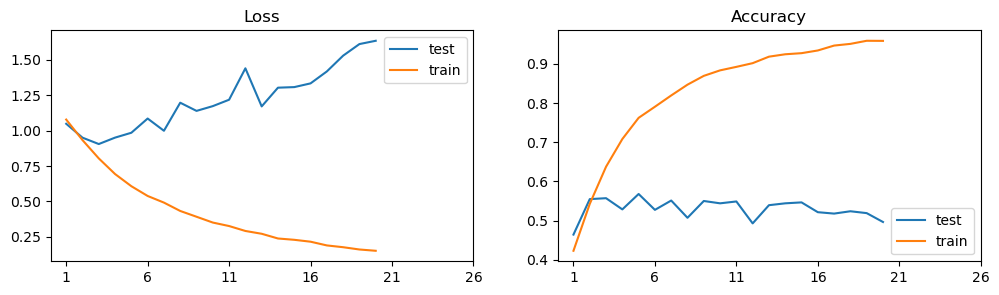

In [19]:
plot_performance('vgg16')

In [20]:
# Evaluate the model
scores = final_model.evaluate(validation_generator, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

  ...
    to  
  ['...']
53/53 [==============================] - 6s 114ms/step - loss: 1.6347 - accuracy: 0.4964
Test loss: 1.6347227437253646
Test accuracy: 0.49642858


In [21]:
y_pred = final_model.predict(validation_generator, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Get true labels from generator
y_true = validation_generator.classes  # Extracts actual labels

# Get class names
class_labels = list(validation_generator.class_indices.keys())  # Maps indices to class names

# Generate classification report
print(classification_report(y_true, y_pred_bool, target_names=class_labels))

53/53 [==============================] - 6s 114ms/step
              precision    recall  f1-score   support

          AD       0.49      0.89      0.63       291
          CN       0.32      0.19      0.24       276
        LMCI       0.70      0.38      0.50       273

    accuracy                           0.50       840
   macro avg       0.51      0.49      0.46       840
weighted avg       0.50      0.50      0.46       840



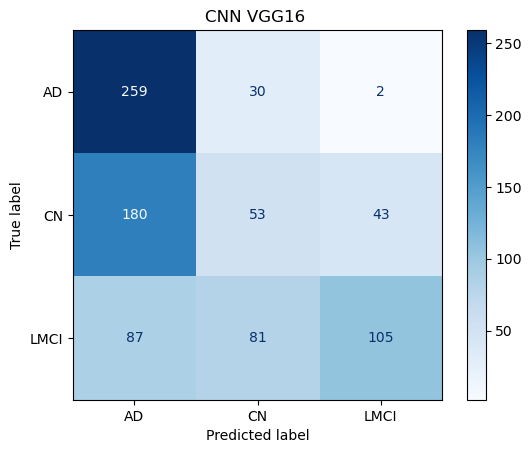

In [22]:
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred_bool)

    # Mostrar la matriz de confusión

    display_labels = ["AD", "CN", "LMCI"]
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots()

    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('CNN ' + 'VGG16 ')
    #plt.show()

    # Save the RF confusion matrix as a JPG image
    #plt.savefig("matriz_confusion_CNN_VGG16.jpg", format="jpg", bbox_inches='tight')
    plt.show()
    plt.close(fig)